This is my initial implementation of training a reinforcement learning model using the PPO2 algorithm on my minesweeper class. I created a Minesweeper Environment using OpenAI's Gym. The PPO2 algorithm is used to learn a model for selecting best actions based on the current state. I had satisfying results from my initial testing, because learning continued to improve with more training steps.

In [1]:
# requires python 3.7, tensorflow 1.15,  (For my reference: conda activate openaigym_minesweeper)
# stable_baselines 2 depends on tensorflow 1.15 which depends on 3.5 >= python <= 3.7
# stable_baselines 2 is used here, but stable_baselines 3 has been released
import minesweeper as ms
import gym
import time
import matplotlib.pyplot as plt
from stable_baselines.common.policies import MlpPolicy
from stable_baselines import PPO2

In [96]:
class MinesweeperTrainer(gym.Env):
    def __init__(self, n, m):
        self.action_space = gym.spaces.Discrete(n ** 2) # possible actions include any tile on the board
        self.observation_space = gym.spaces.MultiDiscrete([10] * (n**2)) # possible states are numbers 0-8 and uncovered tile
            
        self.game = ms.Game(n, m)
    def step(self, action):
        info = {} # blank
        
        result = self.game.rl_action(action)
        
        if(result==3): # a 3 is returned when an illegal action is taken - when a tile is picked that has already been revealed
            reward = -10000
            done = True
        elif(result == 2): # a 2 signifies a victory - all tiles that do not contain mines have been revealed
            reward = 100
            done = True
        elif(result == 1): # a 1 signifies a tile that contains a mine has been selected
            reward = -100
            done = True
        elif(result == 0): # a 0 signifies a tile without a mine has been selected
            reward = 1
            done = False
        
        state = self.game.stateboard.flatten()

        info = {}
        return state, reward, done, info
    
    def reset(self):
        self.game.__init__(self.game.n, self.game.m) # could also just do self.game = ms.Game(n, m)
        state = self.game.stateboard.flatten()
        return state
    
    def render(self):
        display(self.game.stateboard)

In [122]:
def learn(n, m, magnitudes):
    '''
    Create and train a model while recording the average training error as the training progresses
    '''
    avg_rewards = []
    env = MinesweeperTrainer(n, m)
    model = PPO2(MlpPolicy, env, verbose =0)
    for magnitude in magnitudes:
        model.learn(total_timesteps = magnitude) # train for # of timesteps
        total = 0
        for i in range(100): # perform 100 episodes to get average reward
            obs = env.reset()
            while True: # perform an episode of minesweeper
                action, _states = model.predict(obs)
                obs, reward, done, _info = env.step(action)
                total += reward
                if(done == True):
                    break
        avg_rewards.append(total/100) # store the average reward then continue learning
    return model, avg_rewards

In [115]:
magnitudes = [10, 100, 1000 ,10000, 100000, 1000000]
start = time.time()
five_four_model, five_four_rewards = learn(5, 4, magnitudes)
print(time.time() - start) # time to train one million time steps (seconds)

663.2235968112946


In [116]:
start = time.time()
sixteen_forty_model, sixteen_forty_rewards = learn(16, 40, magnitudes)
print(time.time() - start)

1401.8012413978577


In [123]:
more_magnitudes = [10, 100, 1000 ,10000, 100000, 1000000, 10000000]
start = time.time()
ten_fifteen_model, ten_fifteen_rewards = learn(10, 15, more_magnitudes)
print(time.time() - start) # time to train ten million timesteps

8978.353600740433


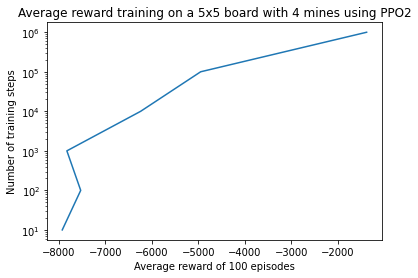

In [130]:
plt.yscale('log')
plt.plot(five_four_rewards, magnitudes);
plt.title('Average reward training on a 5x5 board with 4 mines using PPO2');
plt.xlabel('Average reward of 100 episodes');
plt.ylabel('Number of training steps');

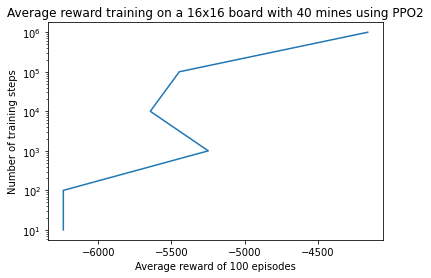

In [131]:
plt.yscale('log')
plt.plot(sixteen_forty_rewards, magnitudes);
plt.title('Average reward training on a 16x16 board with 40 mines using PPO2');
plt.xlabel('Average reward of 100 episodes');
plt.ylabel('Number of training steps');

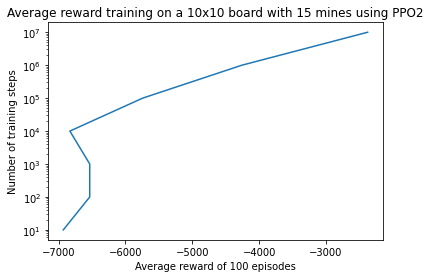

In [132]:
plt.yscale('log')
plt.plot(ten_fifteen_rewards, more_magnitudes);
plt.title('Average reward training on a 10x10 board with 15 mines using PPO2');
plt.xlabel('Average reward of 100 episodes');
plt.ylabel('Number of training steps');

In [133]:
five_four_model.save('five_four_model')
sixteen_forty_model.save('sixteen_forty_model')
ten_fifteen_model.save('ten_fifteen_model')

Learning continues to improve with time, which demonstrates that I properly set up the learning environment. This was my goal for this initial implementation. I used the PPO2 algorithm initially but I will need to learn more about it and other algorithms so I can find the best way to improve learning performance. For now, it seems like improvements could be made by 1) tweaking rewards through a hyperparameter search 
2) learn for more timesteps 
3) tweak PPO2 hyperparameters


I was hoping the model would quickly learn to never take an invalid action by selecting a tile that was already revealed because I gave that action a -10000 reward, but even with ten million timesteps of training it still selected that action sometimes. I think tweaking the rewards could fix that, or I might use a different algorithm. There are many ways to improve training, this notebook just shows the result of my initial model.